# Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style("whitegrid")
import yfinance as yf
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

def d(*obj):
    for o in obj:
        display(o)

def p(*obj):
    for o in obj:
        print(o)

def _np(ls):
    return np.array(ls)

def r(f, unit=3):
    return round(f, unit)

/Users/kyro_m3pro/Desktop/Backtesting/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Get Data

In [2]:
def str_to_float(x:str):
    if type(x) == str:
        return float(x.replace(',' ,''))
    else:
        return x
    
vixf = pd.read_csv('Data/VIXF.csv').set_index('Date')[::-1]
vixf.index = pd.to_datetime(pd.to_datetime(vixf.index).strftime('%Y-%m-%d'))

cols_to_convert = ["Open", "High", "Low", "Price"]
for col in cols_to_convert:
    vixf[col] = vixf[col].apply(str_to_float)

In [3]:
spx = pd.read_csv('Data/SPX.csv', index_col='Date')
spx.index = pd.to_datetime(spx.index)

vix = pd.read_csv('Data/VIX.csv', index_col='Date')
vix.index = pd.to_datetime(vix.index)

In [4]:
df = pd.concat([spx['Adj Close'].rename('SPX'),
                vix['Adj Close'].rename('VIX'),
                vixf['Price'].rename('VIXF')], axis=1)
df = df.dropna()
spread = df['VIXF'] - df['VIX']

# Split

In [5]:
df_train = df.iloc[:int(len(df)*0.7)].copy()
df_test = df.loc[df_train.index[-1]:].copy()

# Transform

In [6]:
def smoothed_rolling_z(raw, window_sma: int, window_z: int):
    smoothed = raw.rolling(window_sma).mean()
    rolling_z = (smoothed - smoothed.rolling(window_z).mean()) / smoothed.rolling(window_z).std()
    return rolling_z

# Optimization (Training)

In [7]:
import sys
sys.path.append('../../qwok/')
from visualization import Visualization as Vis
from signal_oscillator import Price_Oscillator_Signal

In [8]:
reverse_res_arr = []

for window_sma in range(1, 50, 5):
    print(window_sma, end=" ")
    for window_z in range(20, 50, 5):
        rolling_z = smoothed_rolling_z(spread, window_sma, window_z)
        for upper_threshold in np.arange(1.1, 2.8, 0.4):
            for lower_threshold in np.arange(-1.1, -2.8, -0.4):
                for holding_n in range(5, 31):
                    obj_singals = Price_Oscillator_Signal(df['SPX'], rolling_z)
                    signals_reverse = obj_singals.getSignals_OscillatorReverseThreshold(lower_threshold, upper_threshold)
                    obj_bt = Vis(df_train['SPX'], signals_reverse, holding_n=holding_n, ta=rolling_z)
                    res_dict = {
                            'obj_bt': obj_bt,
                            'window_sma': window_sma,
                            'window_z': window_z,
                            'long_resverse_threshold': lower_threshold,
                            'short_resverse_threshold': upper_threshold,
                            'holding_n': holding_n,
                    }
                    for metrics, value in obj_bt.stat.items():
                        res_dict[metrics] = value
                    reverse_res_arr.append(res_dict)

1 6 11 16 21 26 31 36 41 46 

In [9]:
reverse_bt = pd.DataFrame(reverse_res_arr)
reverse_bt = reverse_bt.round(3)

In [10]:
# if 1==0:
#     minima_bt.to_excel('Result (Reverse) 5.0.xlsx')

# Heatmap

In [ ]:
ax = sns.heatmap(reverse_bt.pivot_table(index='window_sma' , columns='window_z', values='sharpe_ratio', aggfunc='mean'))
plt.show()

In [ ]:
ax = sns.heatmap(reverse_bt.pivot_table(columns=['short_resverse_threshold', 'long_resverse_threshold'], index='holding_n', values='sharpe_ratio', aggfunc='mean'))
ax.set_xlabel('Upper Threshold - Lower Threshold')
ax.set_ylabel('Holding N')
plt.show()

## Validate

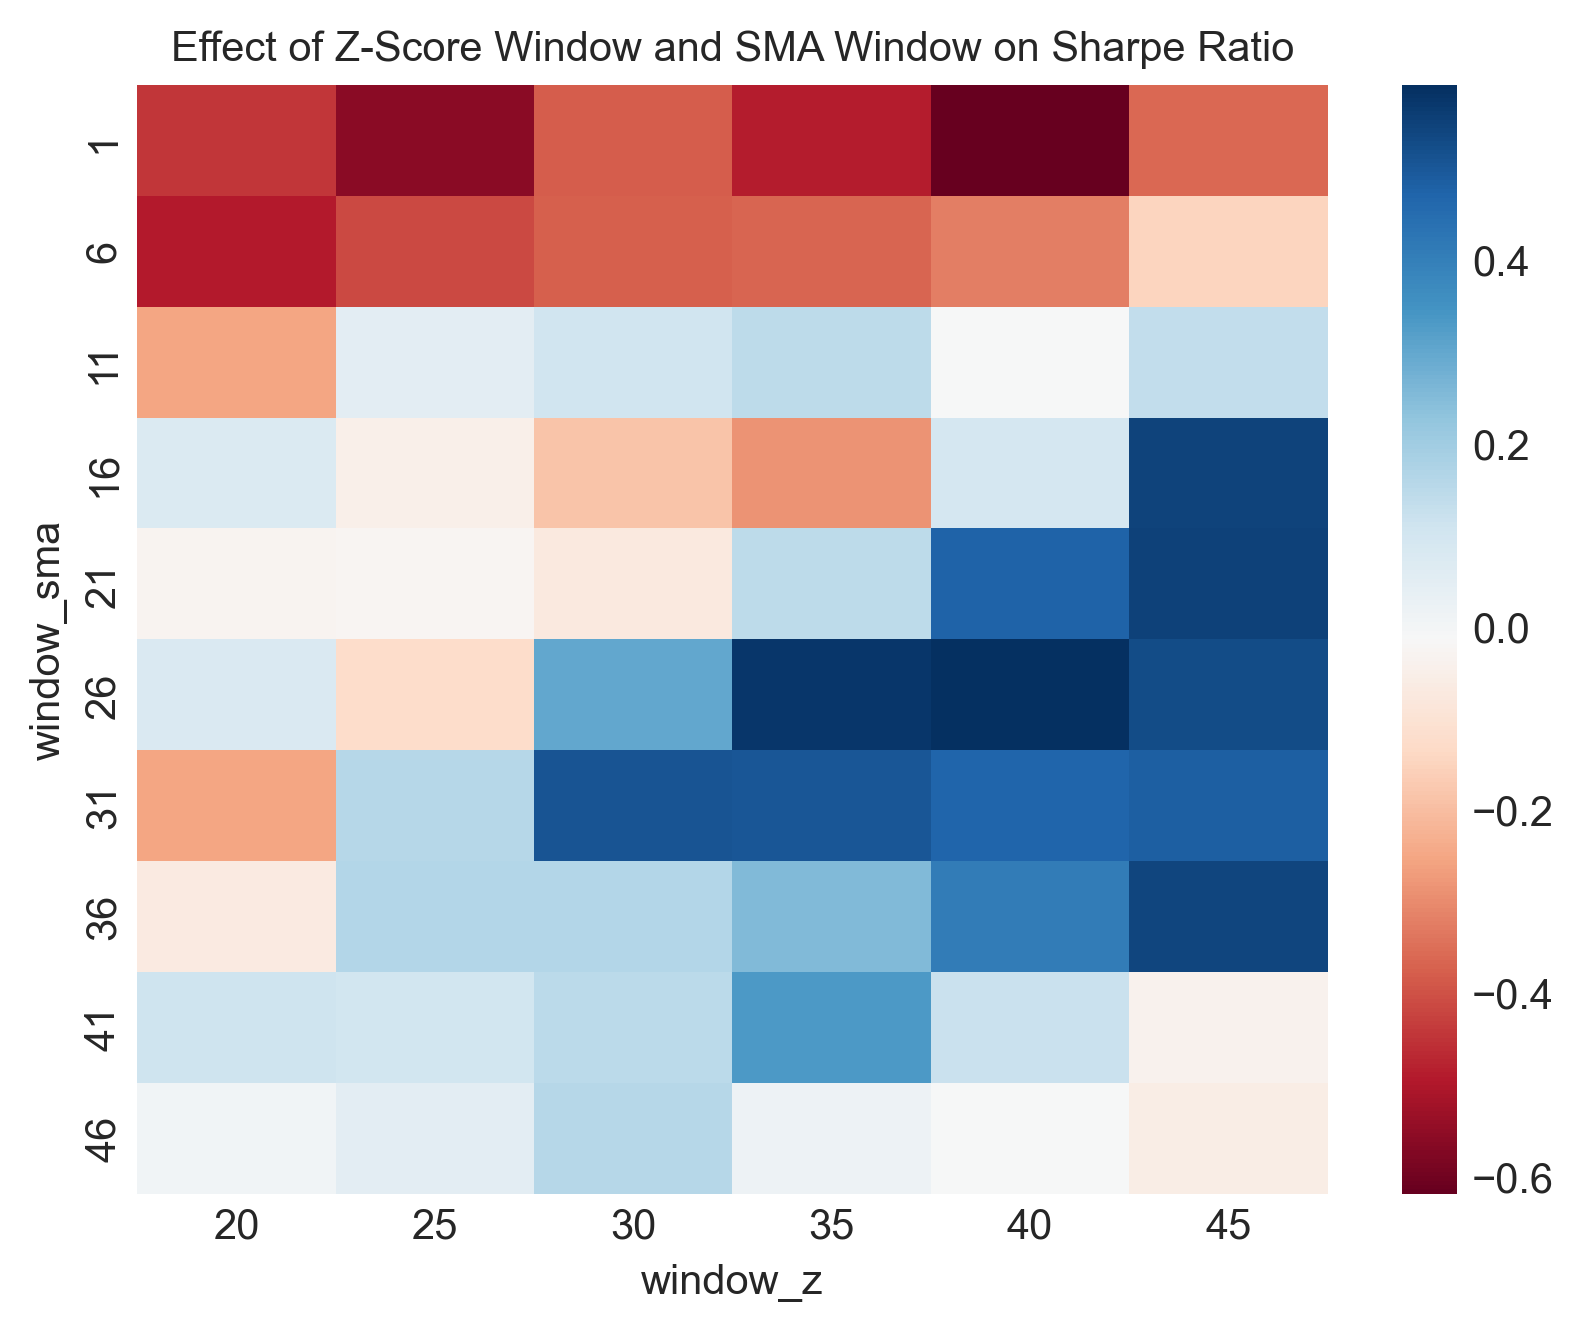

In [11]:
plt.figure(dpi=300)
ax = sns.heatmap(reverse_bt.pivot_table(index='window_sma' , columns='window_z', values='sharpe_ratio', aggfunc='mean'), cmap='RdBu')
plt.title("Effect of Z-Score Window and SMA Window on Sharpe Ratio", fontsize=10)
plt.show()

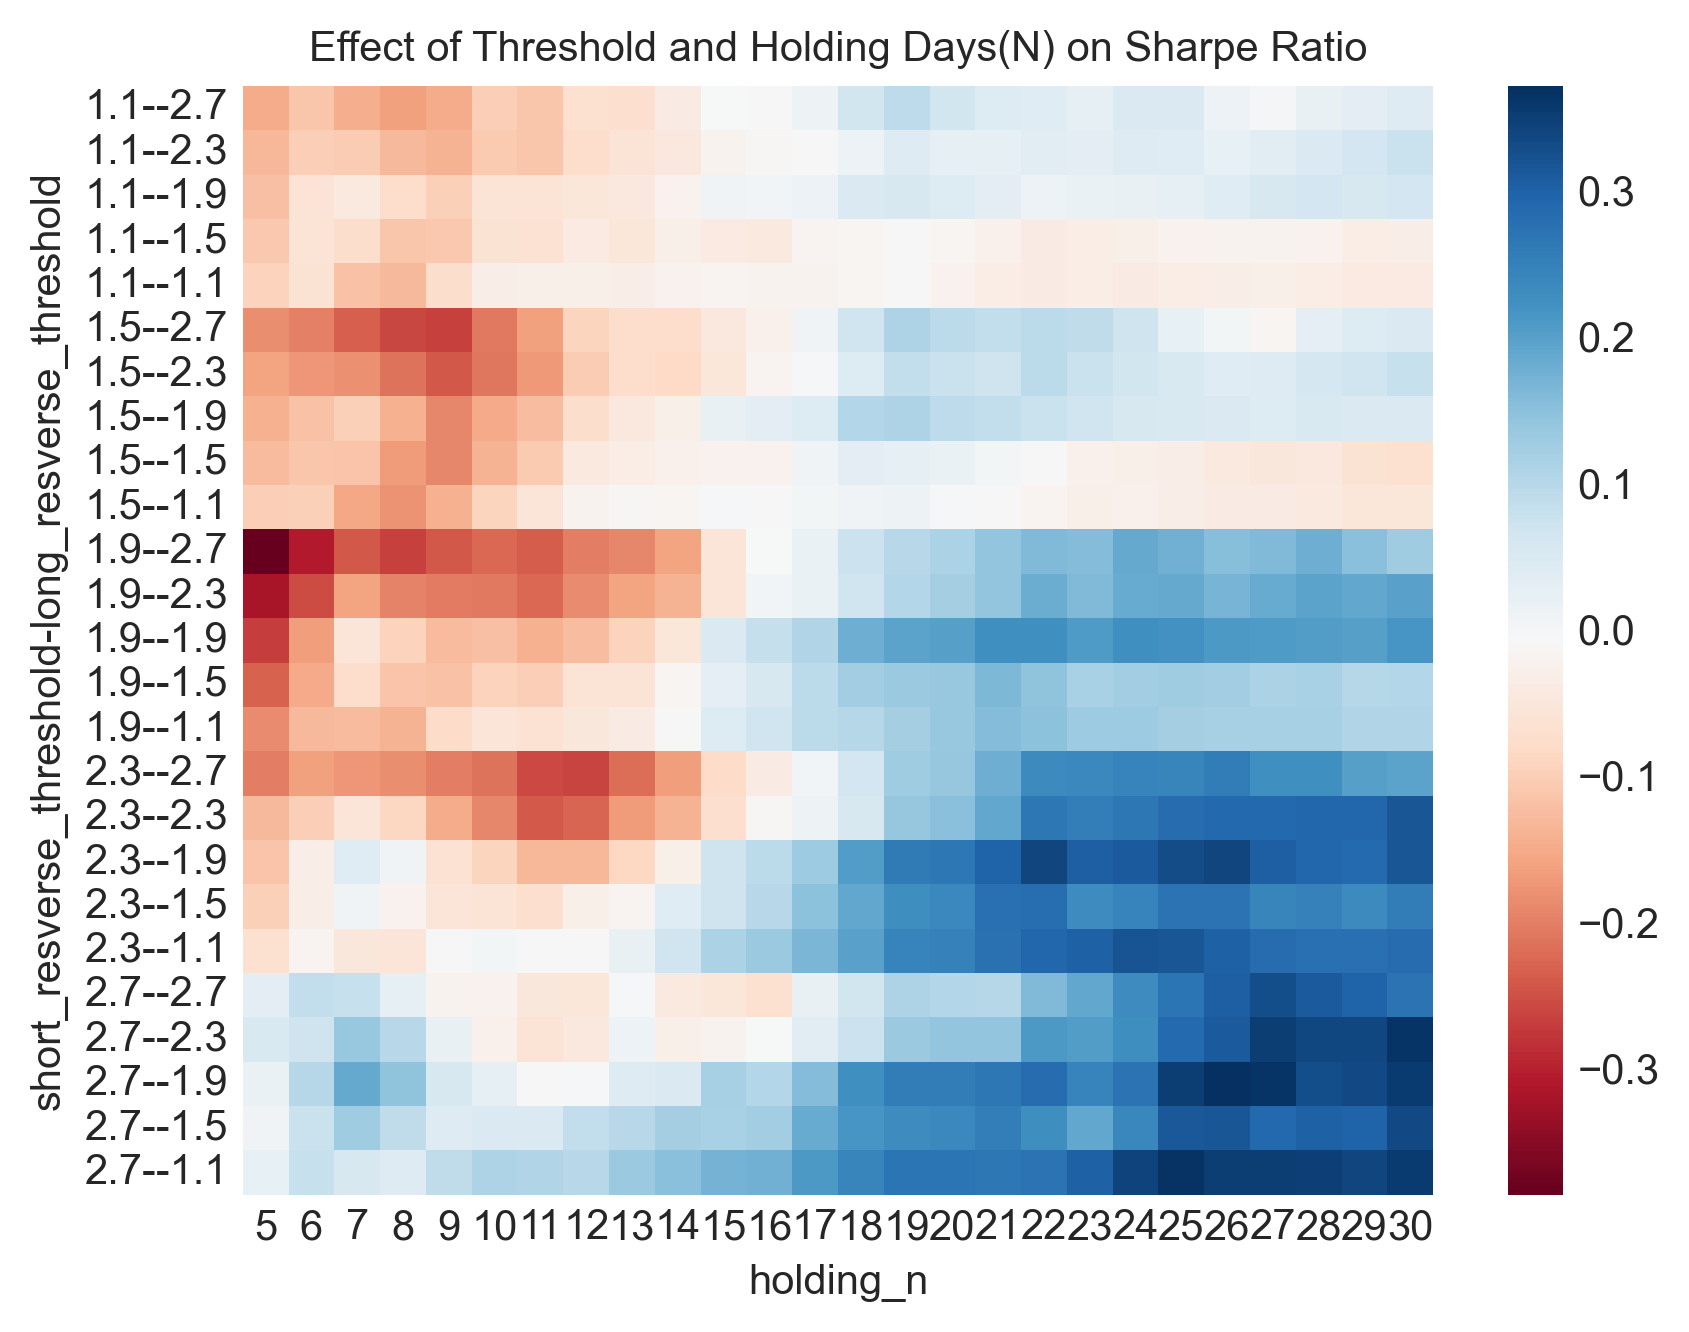

In [12]:
plt.figure(dpi=300)
ax = sns.heatmap(reverse_bt.pivot_table(index=['short_resverse_threshold', 'long_resverse_threshold'], columns='holding_n', values='sharpe_ratio', aggfunc='mean') , cmap='RdBu')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
plt.title("Effect of Threshold and Holding Days(N) on Sharpe Ratio", fontsize=10)
plt.show()

In [13]:
filter_reverse_bt = reverse_bt.copy()
filter_reverse_bt = filter_reverse_bt.loc[filter_reverse_bt['holding_ratio'] > 0.3]
filter_reverse_bt.sort_values(by='calmar_ratio', ascending=False).head(20)
filter_reverse_bt.groupby(by=['window_sma', 'window_z', 'holding_n'])['sharpe_ratio'].max().sort_values()

window_sma  window_z  holding_n
6           35        9           -0.449
            40        7           -0.412
            35        10          -0.410
            45        5           -0.389
            40        8           -0.379
                                   ...  
26          45        5            1.451
21          30        28           1.471
31          40        9            1.490
21          25        28           1.504
26          45        8            1.554
Name: sharpe_ratio, Length: 1560, dtype: float64

# Validation

In [14]:
idx = 23212 # 23212
print(reverse_bt.iloc[idx])
this_obj = reverse_bt.loc[idx, 'obj_bt']

obj_bt                       <visualization.Visualization object at 0x34b9a...
window_sma                                                                  26
window_z                                                                    45
long_resverse_threshold                                                   -1.9
short_resverse_threshold                                                   2.3
holding_n                                                                   25
start                                                      2022-01-03 00:00:00
end                                                        2023-08-09 00:00:00
len_timeframe                                                              402
leverage                                                                     1
resolution(hr)                                                            24.0
count_day_tradable_yearly                                                  252
long_short_ratio                                    

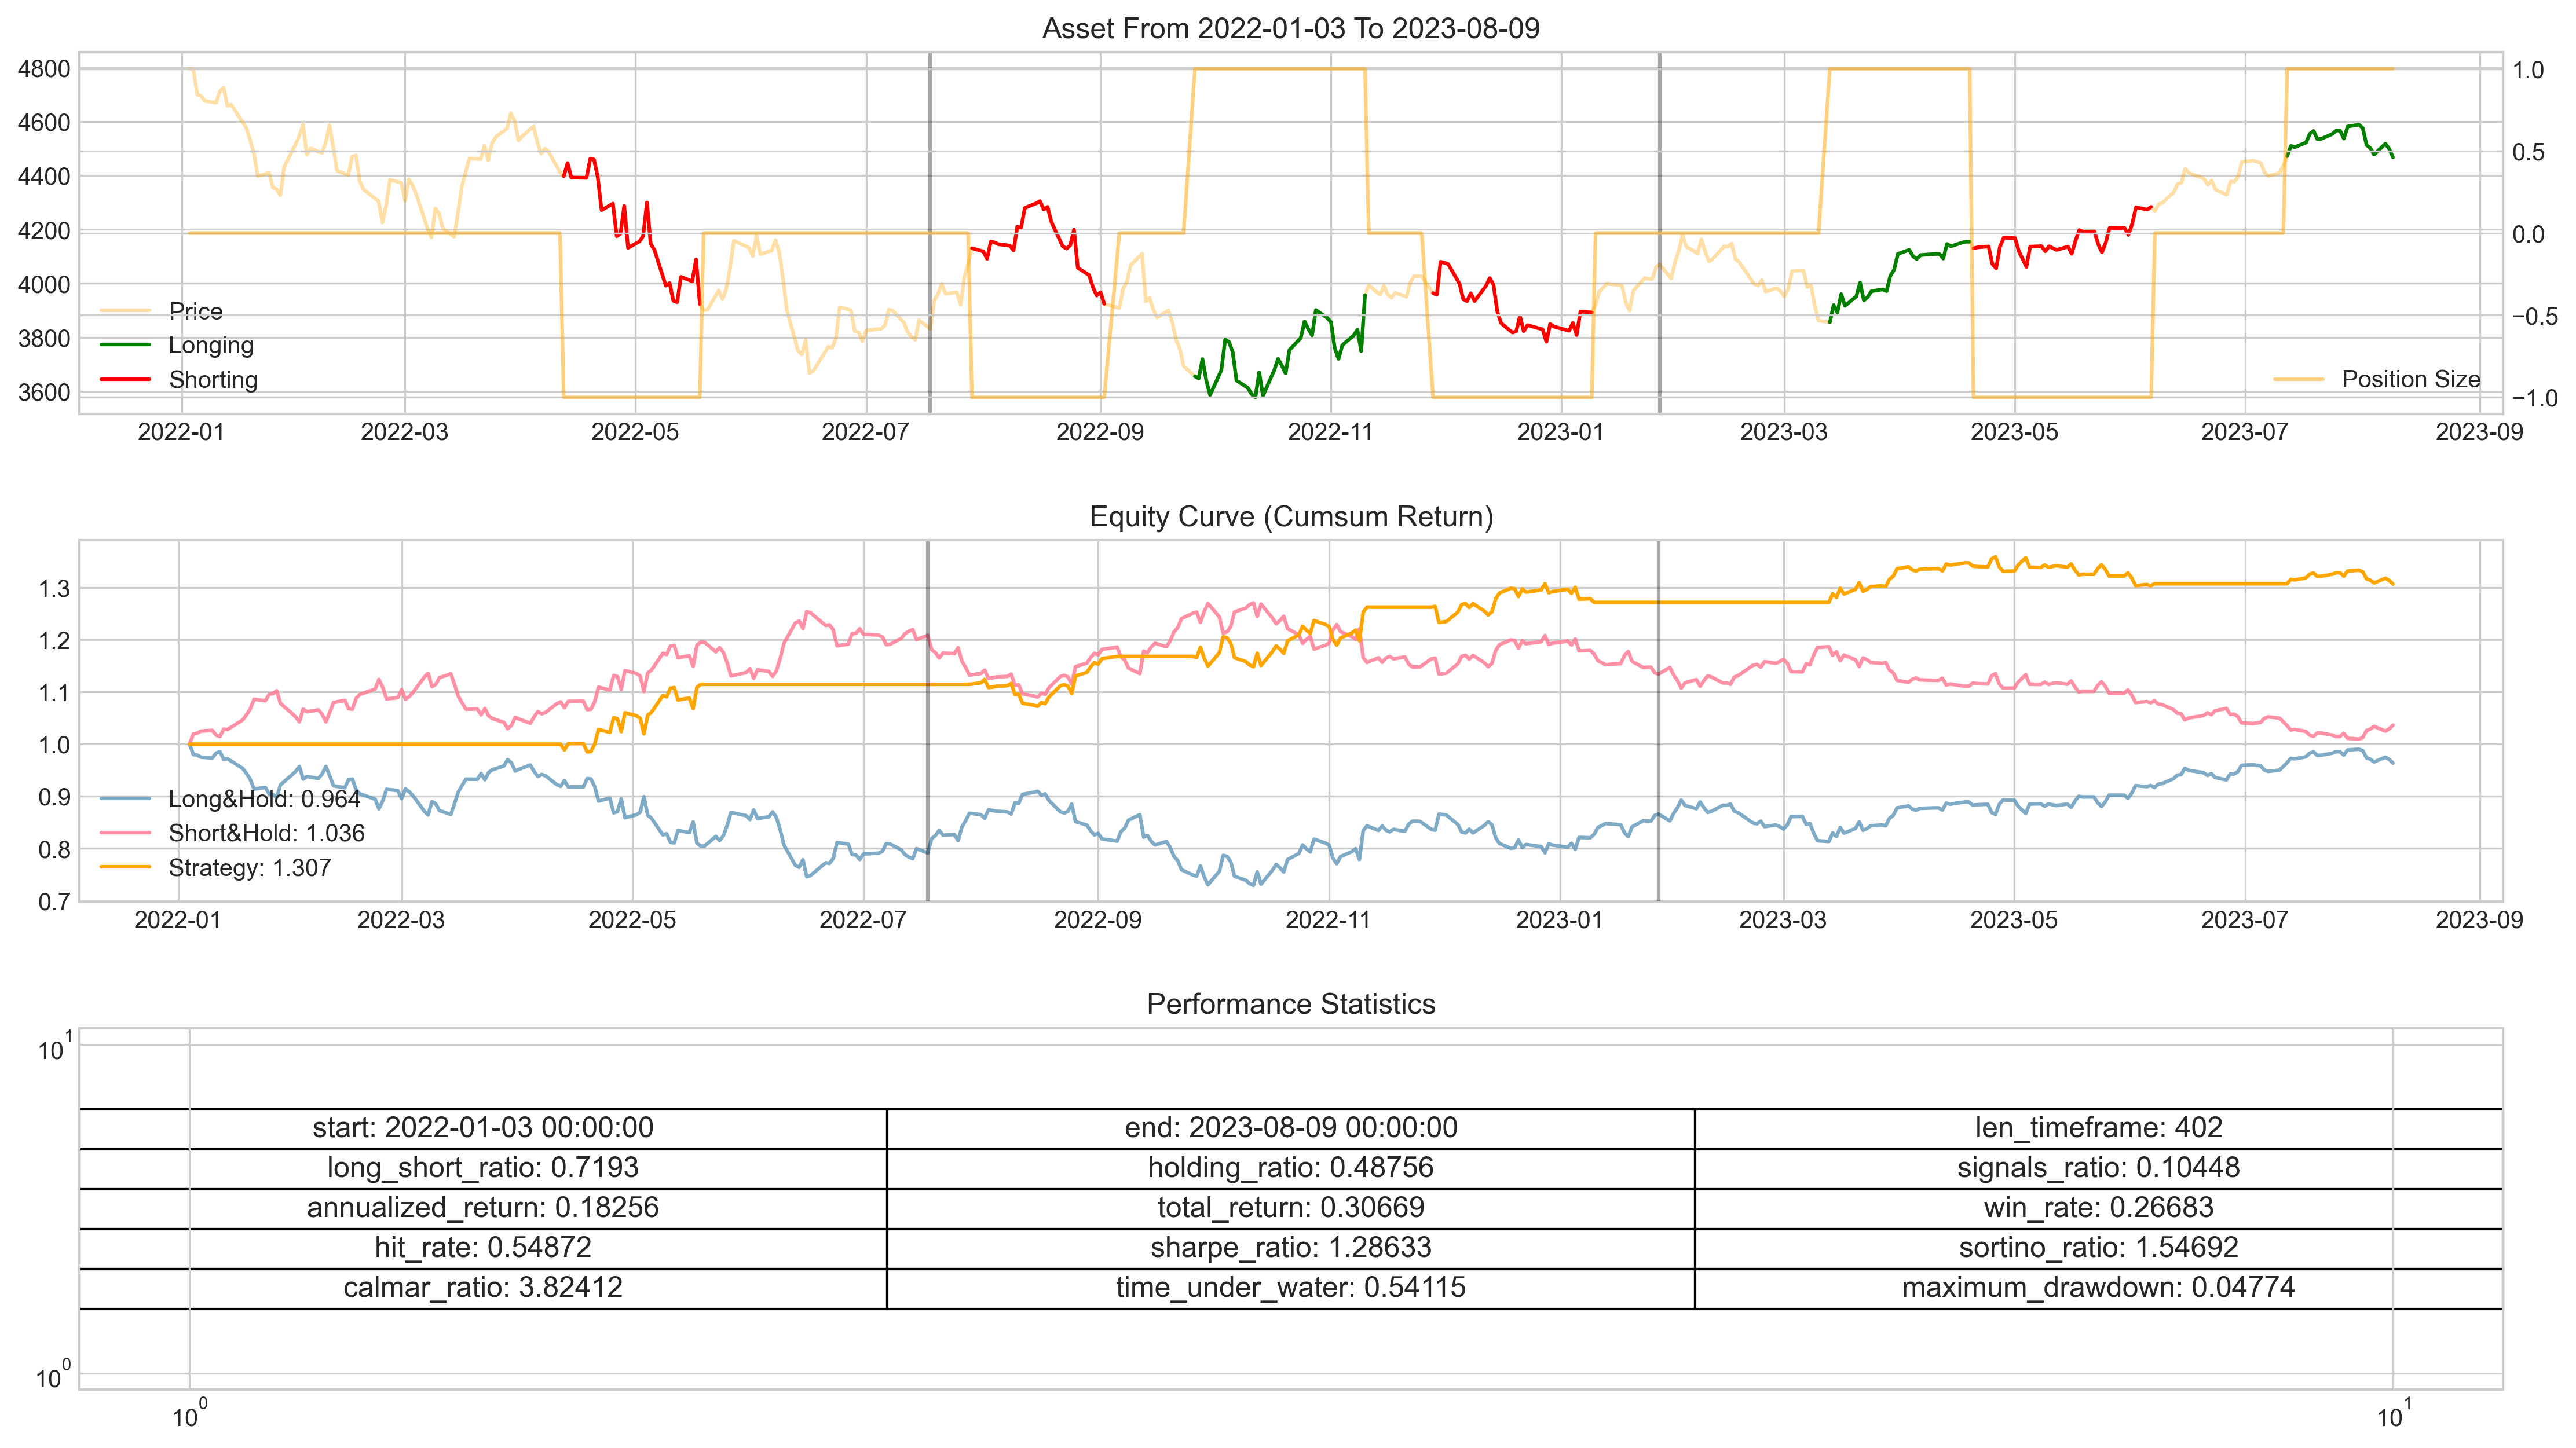

In [15]:
this_obj.plot_general(config_position={'plot':True})

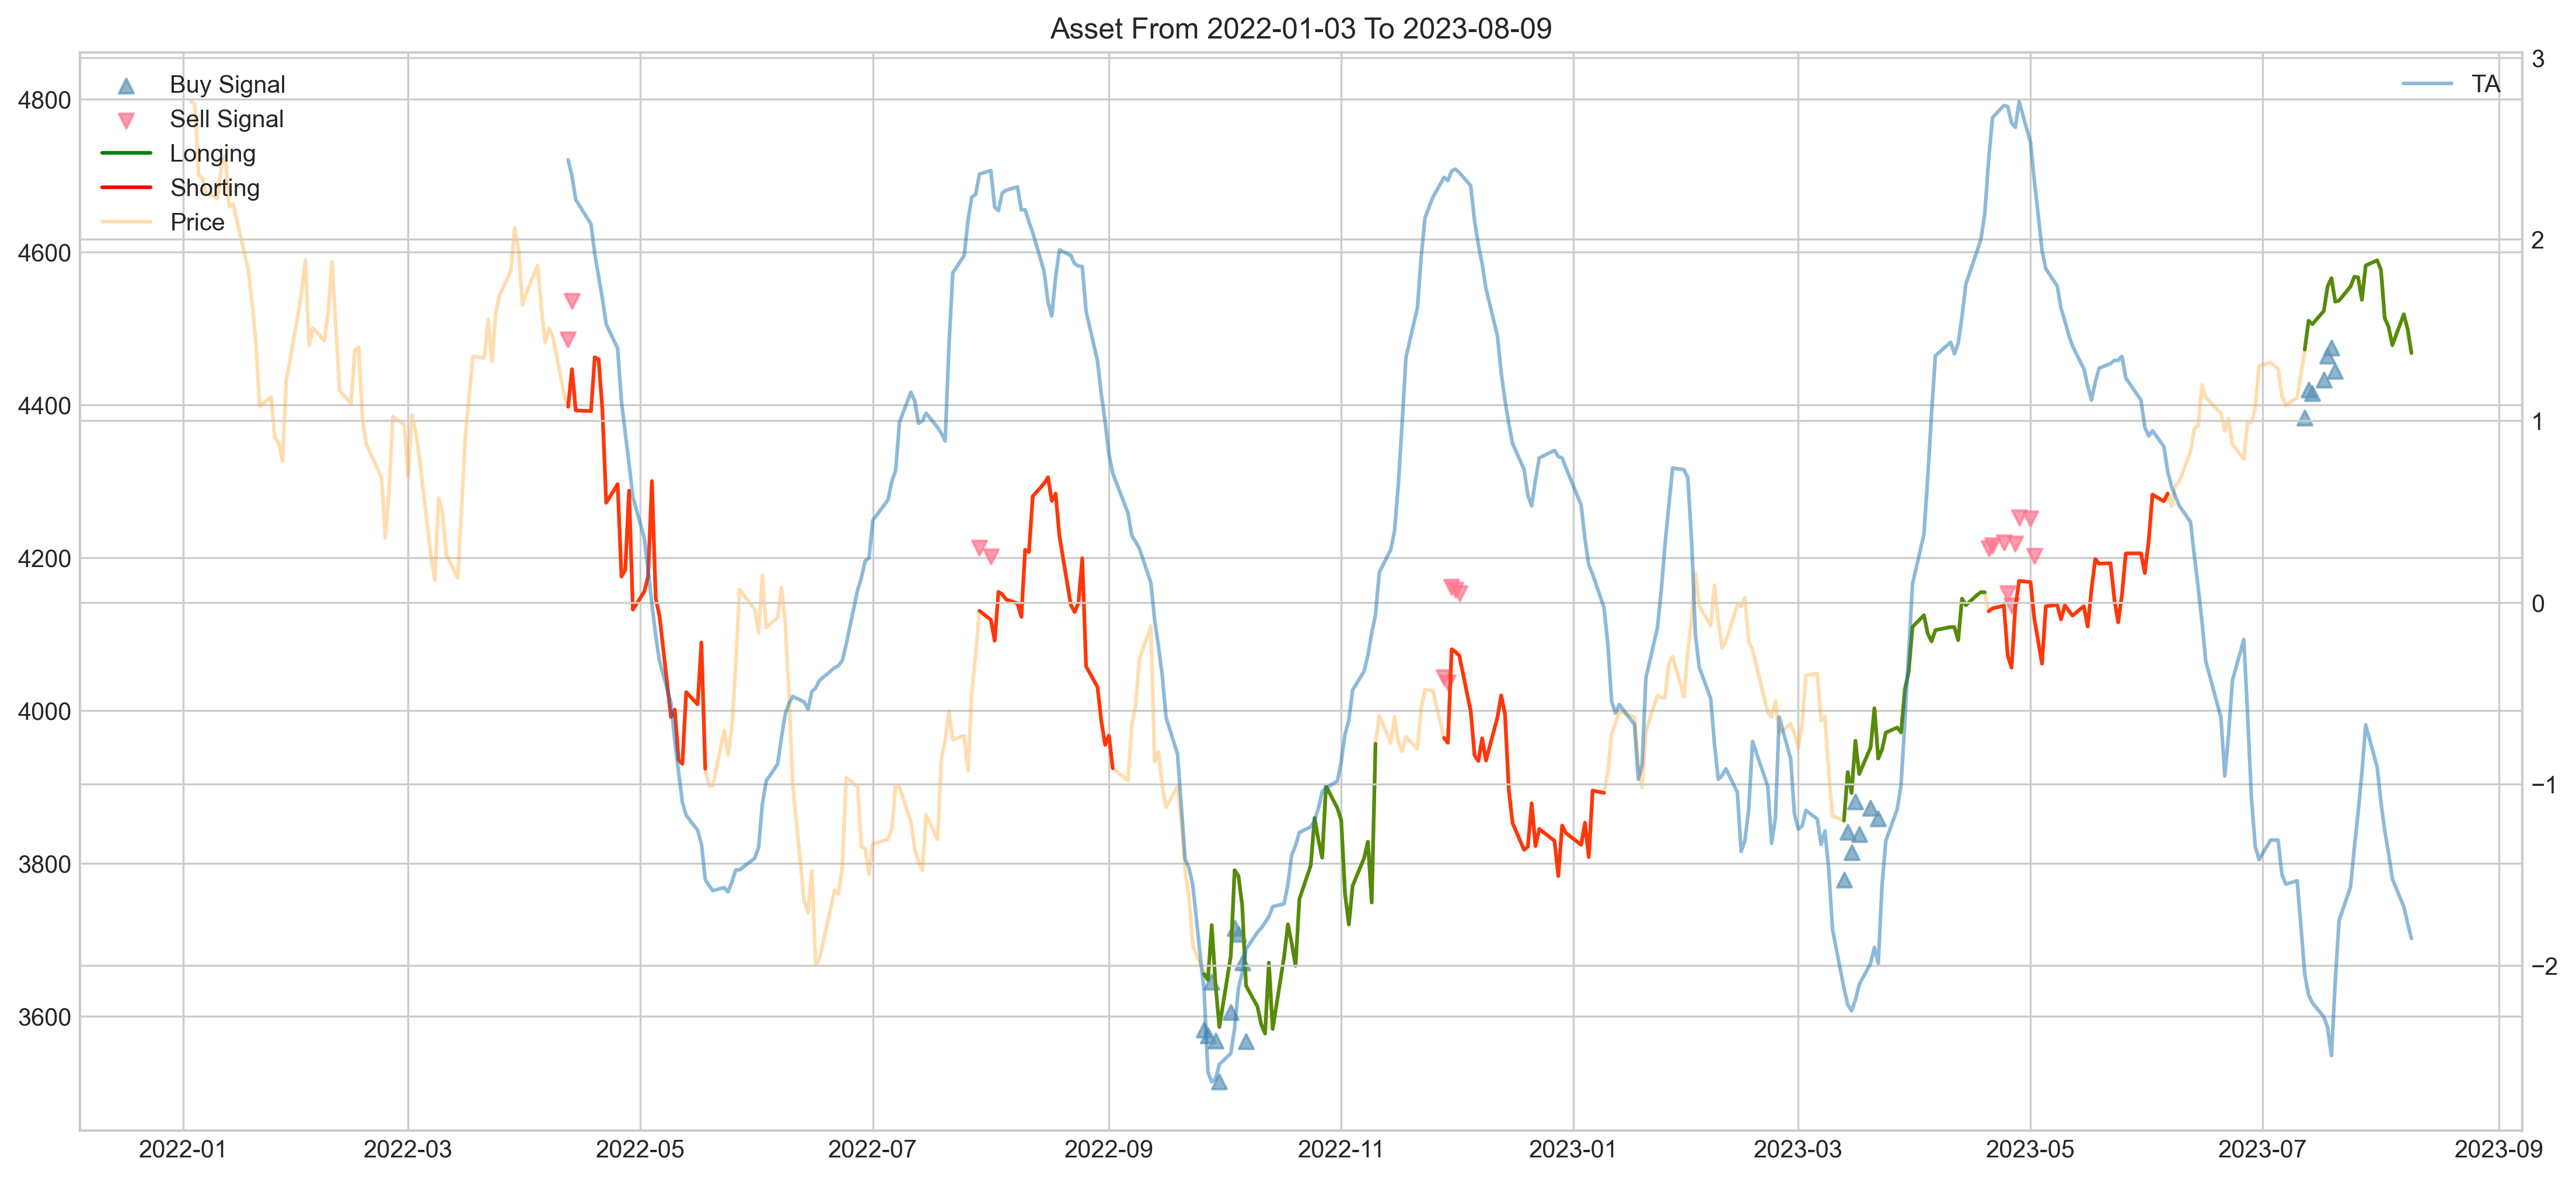

In [16]:
this_obj.plot_signal(plot_extend_position=False)

# Verifcation

In [22]:
# window_sma,	window_z, lower_threshold, upper_threshold, holding_n = reverse_bt.iloc[idx, 1:6] # 31151
window_sma,	window_z, lower_threshold, upper_threshold, holding_n = 26, 45, -1.9, 2.3, 25
print(window_sma,	window_z, lower_threshold, upper_threshold, holding_n)

rolling_z = smoothed_rolling_z(spread, window_sma, window_z)

obj_singals = Price_Oscillator_Signal(df_test['SPX'], rolling_z)
signals_minima = obj_singals.getSignals_OscillatorReverseThreshold(lower_threshold, upper_threshold)

26 45 -1.9 2.3 25


In [23]:
bt_obj = Vis(df_test['SPX'], signals_minima, ta=rolling_z, holding_n=holding_n, asset_name='SPX')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


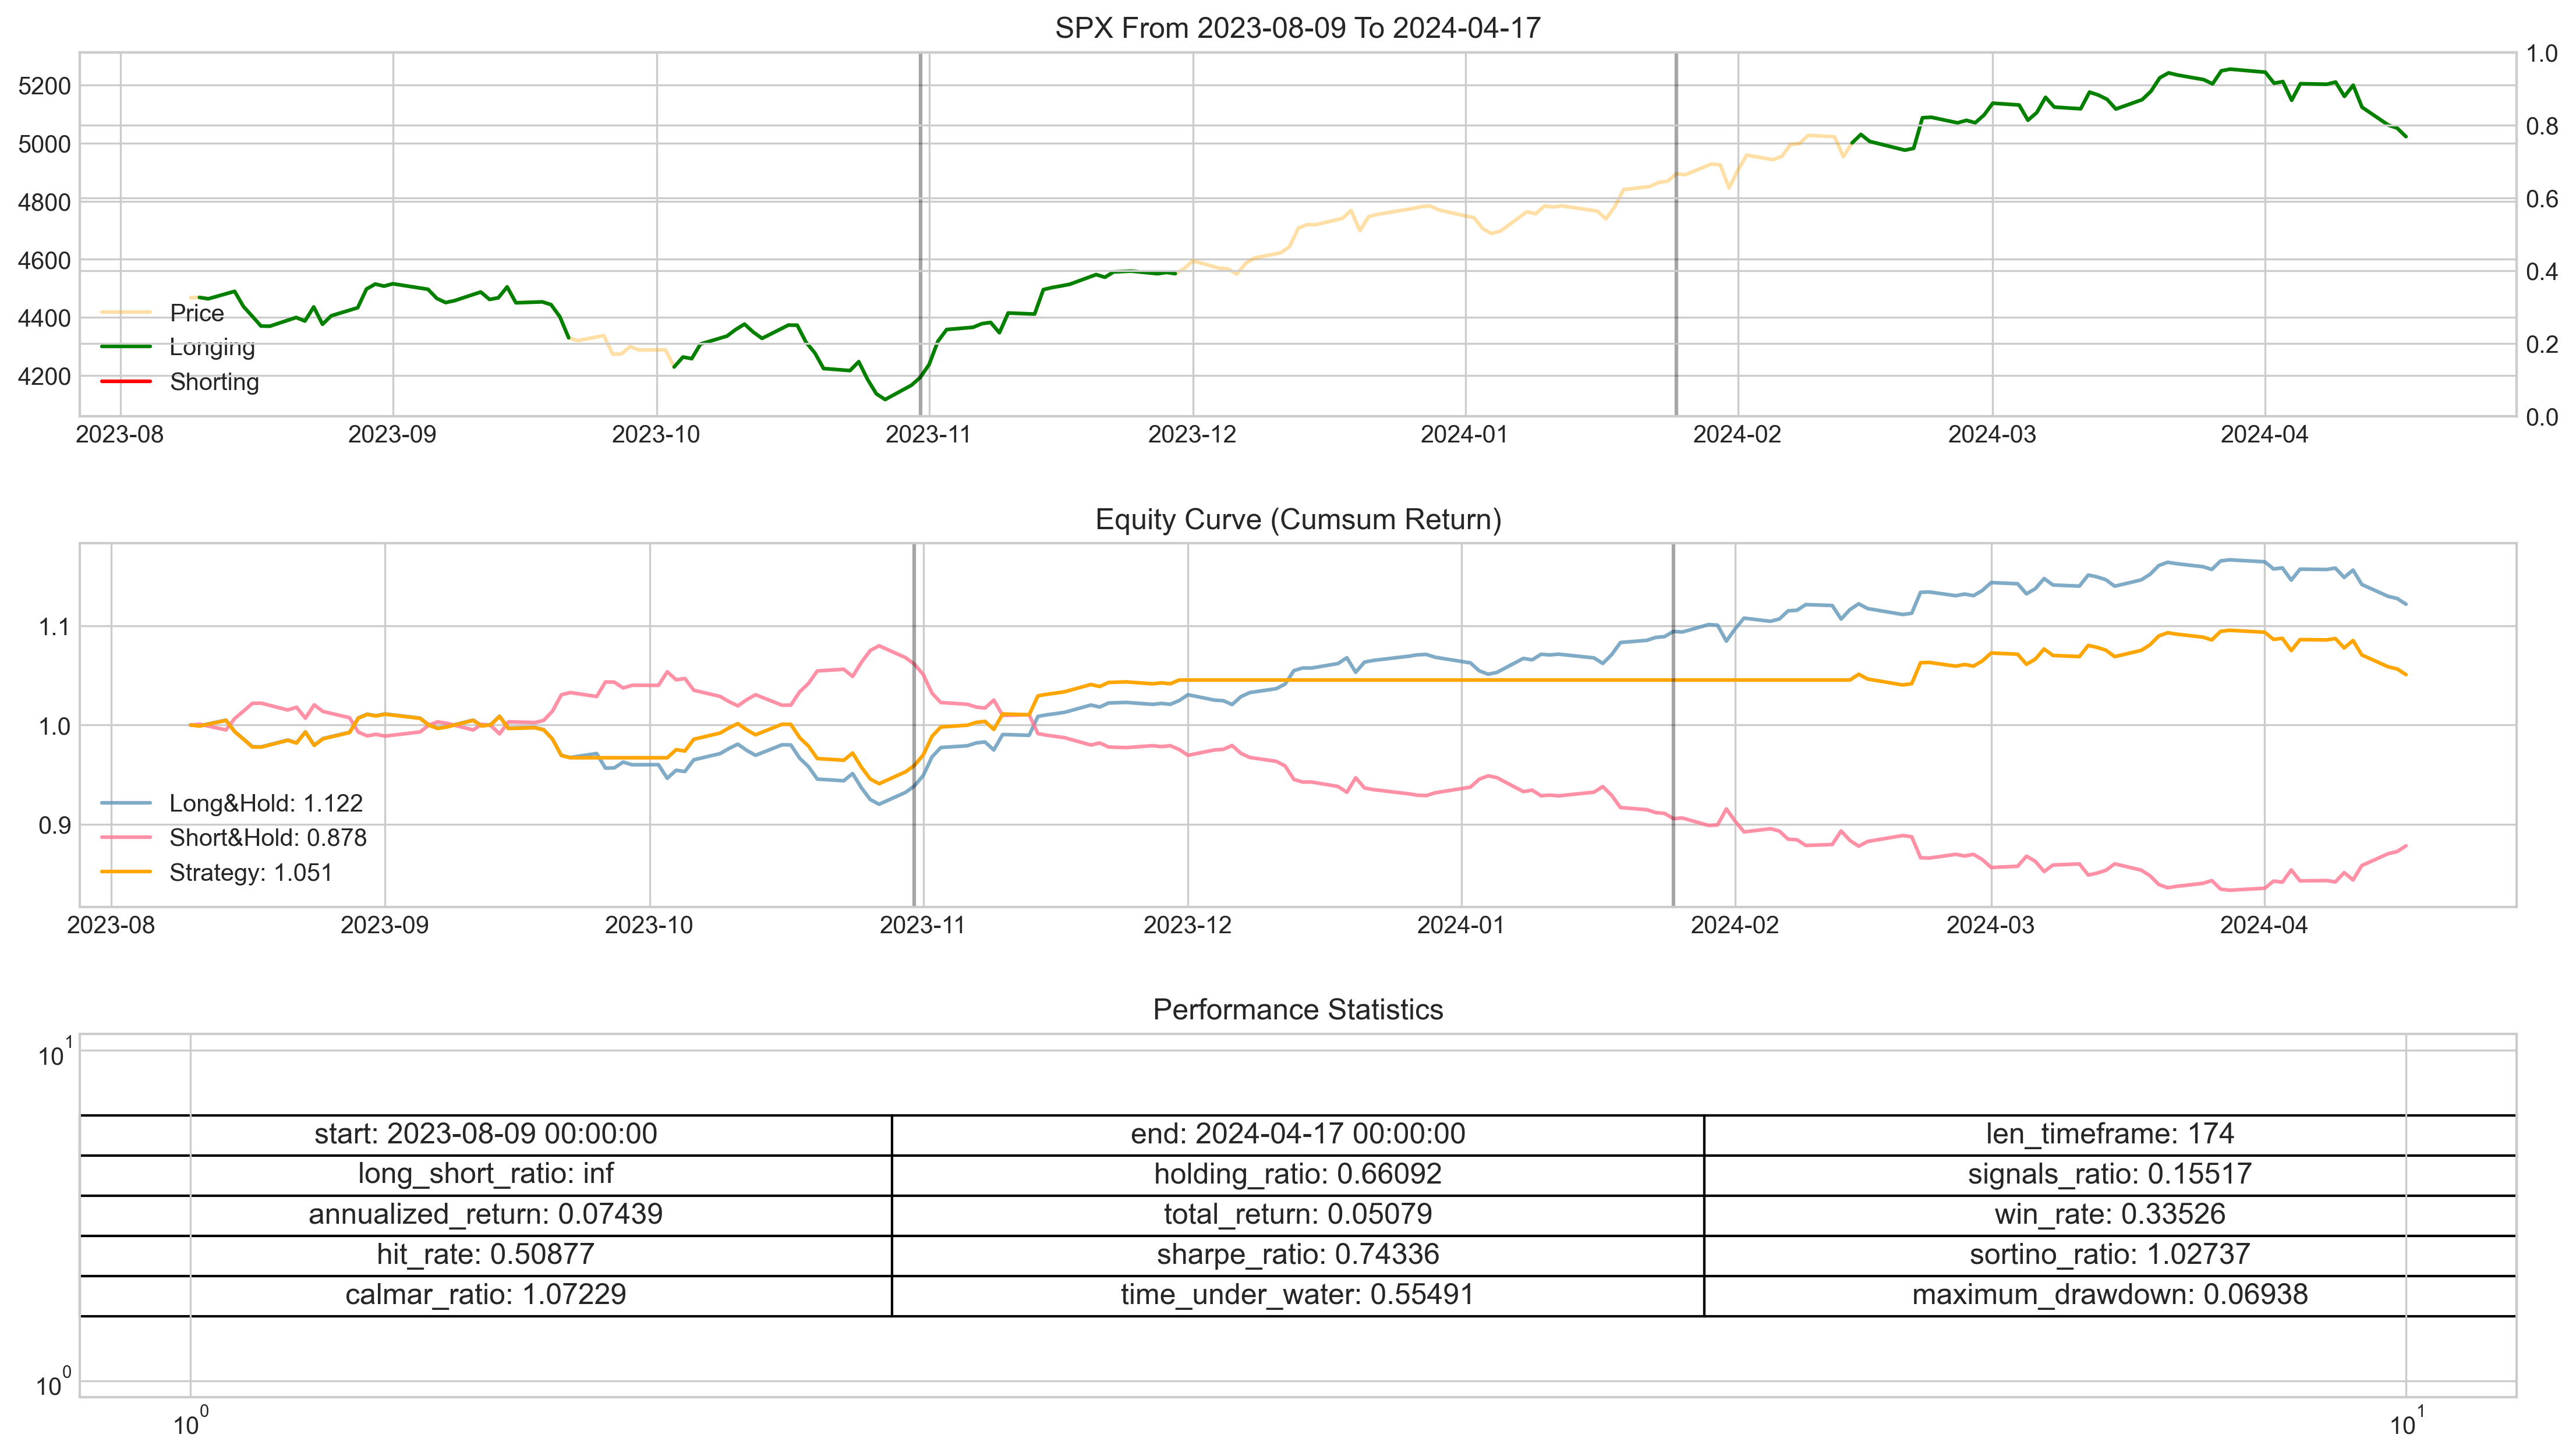

In [24]:
bt_obj.plot_general(config_position={'plot':False}, important_stat_only=True)

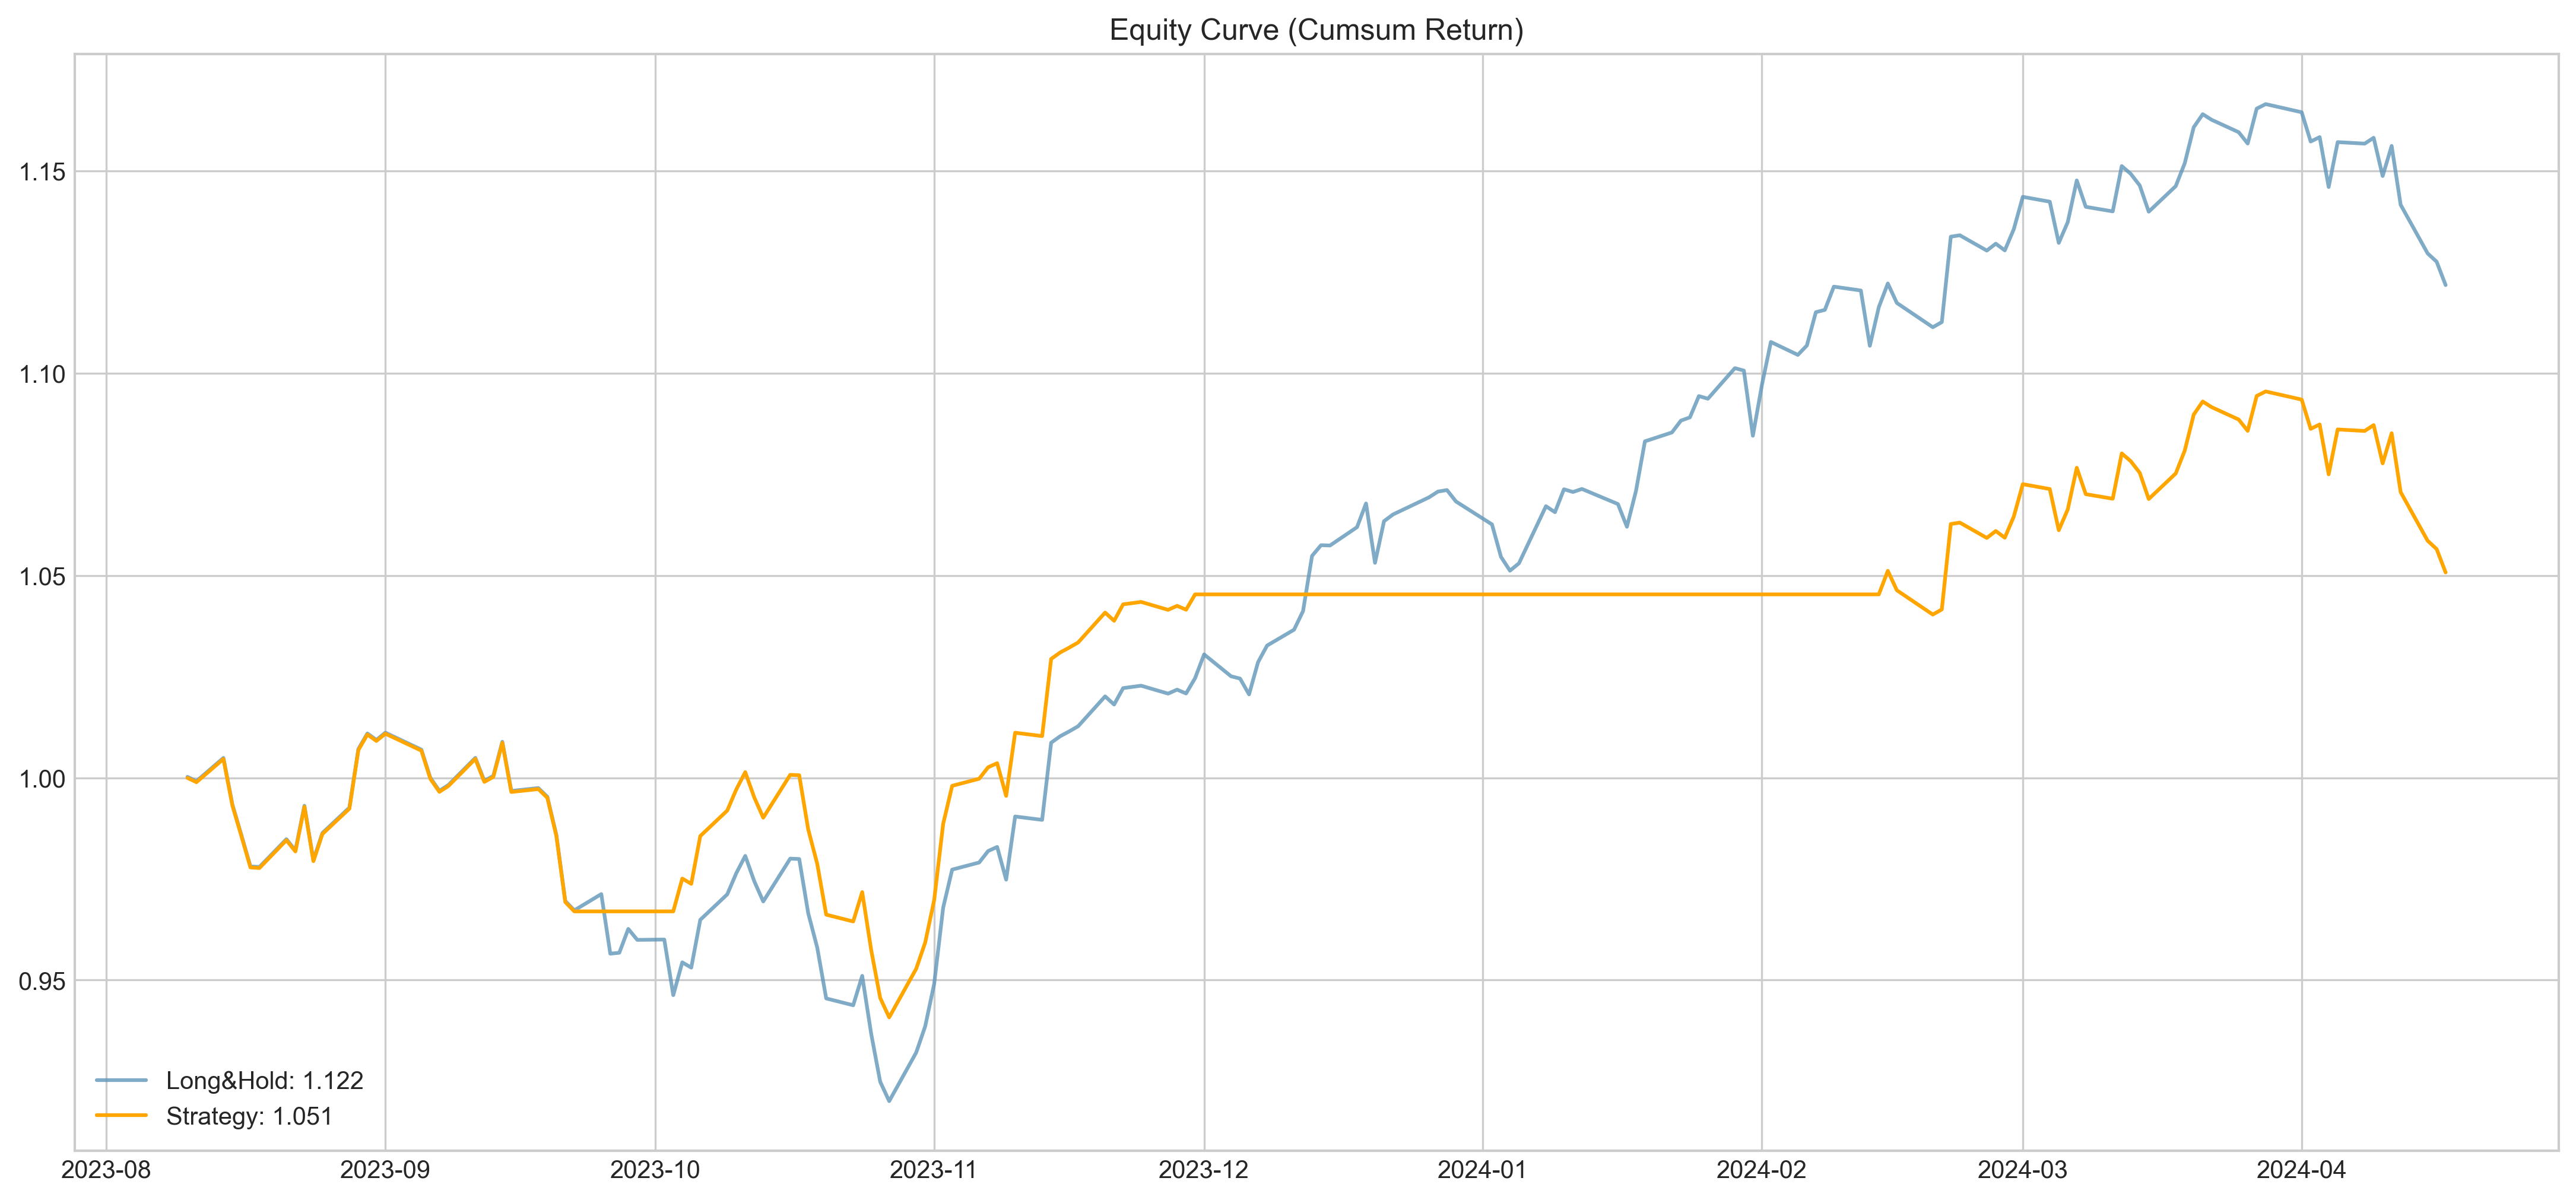

In [25]:
bt_obj.plot_equityCurve(plot_long=True, plot_short=False)

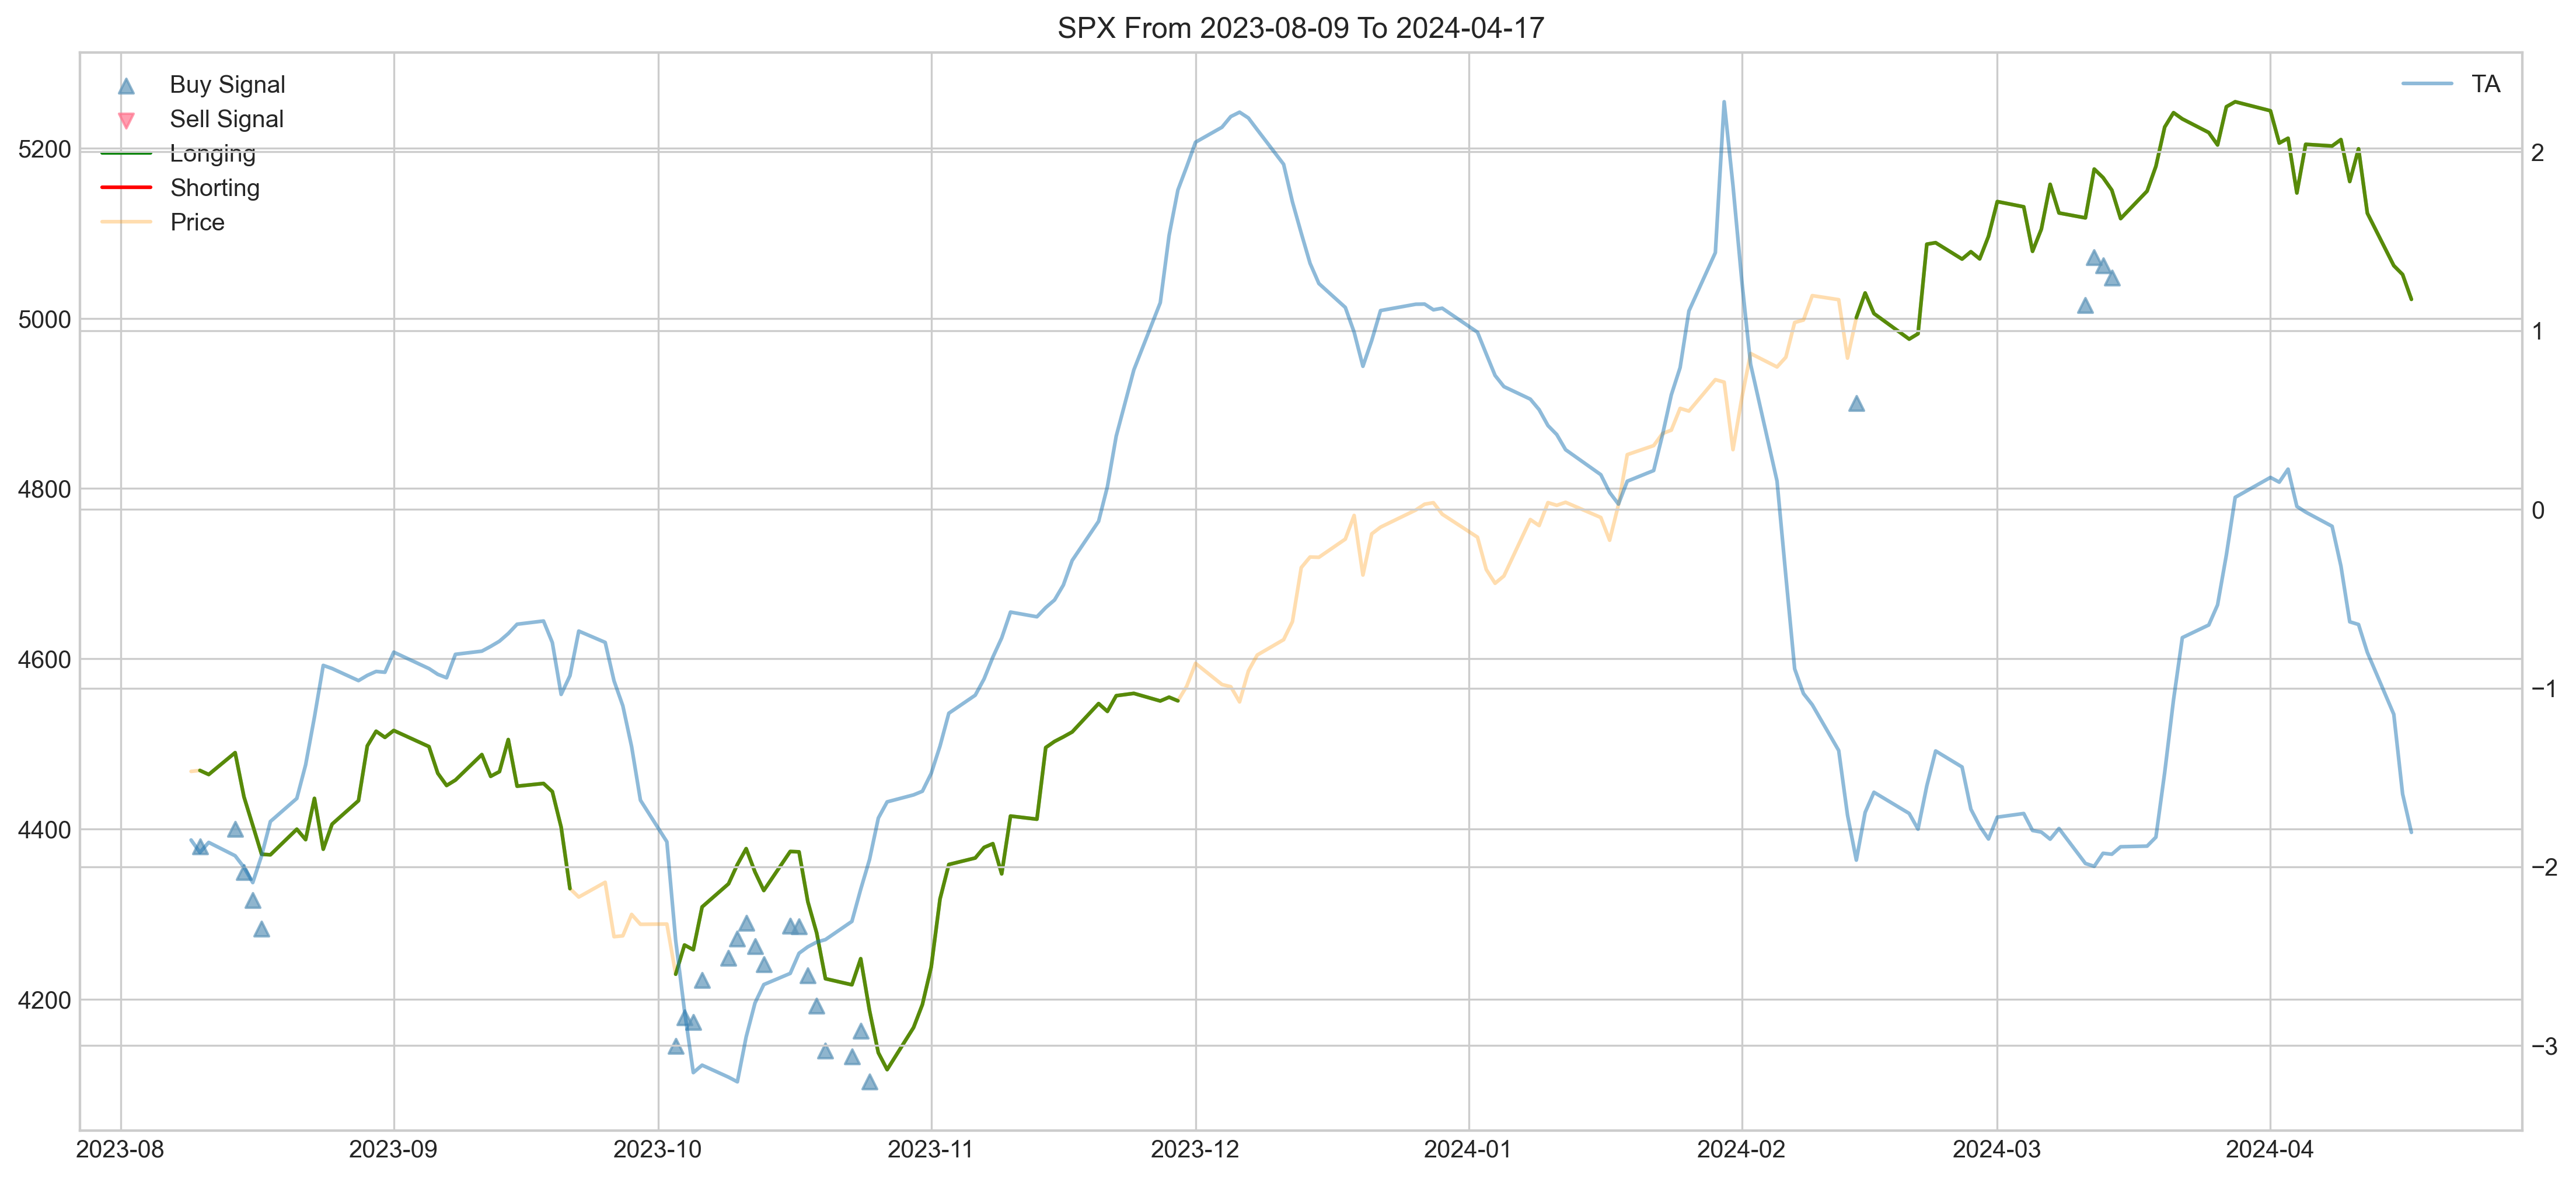

In [26]:
bt_obj.plot_signal(plot_extend_position=False)

In [27]:
pd.concat([bt_obj.df_bt.tail(20), bt_obj.ta.tail(20)], axis=1)

,Open,Close,Return,Position,PnL,0
2024-03-20 00:00:00,NaN,5224.620117,0.008904,1.0,0.008904,-1.471287
2024-03-21 00:00:00,NaN,5241.529785,0.003237,1.0,0.003237,-1.065792
2024-03-22 00:00:00,NaN,5234.180176,-0.001402,1.0,-0.001402,-0.717473
2024-03-25 00:00:00,NaN,5218.189941,-0.003055,1.0,-0.003055,-0.646748
2024-03-26 00:00:00,NaN,5203.580078,-0.002800,1.0,-0.002800,-0.534274
2024-03-27 00:00:00,NaN,5248.490234,0.008631,1.0,0.008631,-0.254408
2024-03-28 00:00:00,NaN,5254.350098,0.001116,1.0,0.001116,0.067458
2024-04-01 00:00:00,NaN,5243.770020,-0.002014,1.0,-0.002014,0.178809
2024-04-02 00:00:00,NaN,5205.810059,-0.007239,1.0,-0.007239,0.152416
2024-04-03 00:00:00,NaN,5211.490234,0.001091,1.0,0.001091,0.225046
